# Football Statistics Task

_Finlay O'Neill_


Objectives:
1. A statistical analysis of the data, including quality assessments 
2. Visualisations that help the narrative
3. Attempts at predicting winners of a competition

## Import libraries

In [219]:
import json
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score

## Import the competition matches data from GitHub

[Link to Data](https://github.com/statsbomb/open-data/tree/master/data/matches/11)


In [220]:
file_n = [1,2,4,21,22,23,24,25,26,27,37,38,39,40,41,42]
matches = []

for n in file_n:
    
    url = f'https://raw.githubusercontent.com/statsbomb/open-data/master/data/matches/11/{n}.json'
    response = requests.get(url)
    data = json.loads(response.text)
    matches.extend(data)

## Data Analysis

See how many observations there are.

Look at the first element in the `matches` list to have a look at the structure, keys and values.

In [221]:
len(matches)

485

In [222]:
matches[0]

{'match_id': 9592,
 'match_date': '2017-09-09',
 'kick_off': '20:45:00.000',
 'competition': {'competition_id': 11,
  'country_name': 'Spain',
  'competition_name': 'La Liga'},
 'season': {'season_id': 1, 'season_name': '2017/2018'},
 'home_team': {'home_team_id': 217,
  'home_team_name': 'Barcelona',
  'home_team_gender': 'male',
  'home_team_group': None,
  'country': {'id': 214, 'name': 'Spain'},
  'managers': [{'id': 227,
    'name': 'Ernesto Valverde Tejedor',
    'nickname': 'Ernesto Valverde',
    'dob': None,
    'country': {'id': 214, 'name': 'Spain'}}]},
 'away_team': {'away_team_id': 214,
  'away_team_name': 'Espanyol',
  'away_team_gender': 'male',
  'away_team_group': None,
  'country': {'id': 214, 'name': 'Spain'},
  'managers': [{'id': 236,
    'name': 'Enrique Sánchez Flores',
    'nickname': 'Quique Sánchez Flores',
    'dob': None,
    'country': {'id': 214, 'name': 'Spain'}}]},
 'home_score': 5,
 'away_score': 0,
 'match_status': 'available',
 'last_updated': '2020-0

There's some nested structure to the dictionary object, but it looks like it could be flattened so that the data can be converted to a dataframe. There's a mixture of quantitative and categorical data types. 

Check that only La Liga data and regular season data is being analysed

In [223]:
league_name = [n['competition']['competition_name'] for n in matches]
set(league_name)

{'La Liga'}

In [224]:
competition = [n['competition_stage']['name'] for n in matches]
set(competition)

{'Regular Season'}

## Variable Selection

It looks like there are a number of variables that could be useful for predicting the outcome of the football matches. As an initial example, an investigation into whether the winner of a football match can be predicted. This will be performed on the total dataset. 

The variables of interest are extracted from the `matches` dictionary object and used in the construction of the `matches_df` dataframe object. These are given below. 

In [225]:
matches_df = pd.DataFrame(
    index = [n['match_id'] for n in matches],
    data = {
        'match_dates': [n['match_date'] for n in matches],
        'kick_offs': [n['kick_off'] for n in matches],
        'season_names': [n['season']['season_id'] for n in matches],
        'home_teams': [n['home_team']['home_team_id'] for n in matches],
        # 'home_team_managers': [n['home_team']['managers'][0]['name'] for n in matches],
        'away_teams': [n['away_team']['away_team_id'] for n in matches],
        # 'away_team_managers':[n['away_team']['managers'][0]['name'] for n in matches],
        'home_scores': [n['home_score'] for n in matches],
        'away_scores': [n['away_score'] for n in matches],
        'match_weeks': [n['match_week'] for n in matches],
        # 'stadiums': [n['stadium']['name'] for n in matches],
        # 'referees': [n['referee']['name'] for n in matches],
    }
)

matches_df['home_team_wins'] = (matches_df['home_scores'] > matches_df['away_scores']).astype(int)
# matches_df['result_draw'] = (matches_df['home_scores'] == matches_df['away_scores']).astype(int)

The variables `home_team_managers`, `away_team_managers`, `stadiums` and `referees` appear to have missing values for some of the matches in the data extracted from GitHub. For the purposes of the analysis, they are excluded. 

The `home_team_wins` feature is engineered and will be used as the target variable to be predicted. 

Inspecting `matches_df` is useful to inspect the data types and quality.

In [226]:
matches_df.sort_values('match_dates', inplace = True)
matches_df.head()

,match_dates,kick_offs,season_names,home_teams,away_teams,home_scores,away_scores,match_weeks,home_team_wins
68353,2004-10-16,22:00:00.000,37,214,217,0,1,7,0
68313,2004-10-24,21:00:00.000,37,217,422,3,0,8,1
68314,2004-12-04,20:00:00.000,37,217,223,4,0,14,1
69153,2004-12-11,20:00:00.000,37,608,217,1,2,15,0
68315,2004-12-21,20:00:00.000,37,217,221,2,1,17,1


Its also clear that Barcelona are either the home or away team in 100% of the matches. This makes predicting the winner of the league for a given season difficult as there is an incomplete dataset. 

In [229]:
h = [n['home_team']['home_team_name'] for n in matches]
a = [n['away_team']['away_team_name'] for n in matches]

teams_list = list(zip(h, a))
teams_list[:10]

[('Barcelona', 'Espanyol'),
 ('Barcelona', 'Leganés'),
 ('Espanyol', 'Barcelona'),
 ('Barcelona', 'Eibar'),
 ('Barcelona', 'Celta Vigo'),
 ('Sevilla', 'Barcelona'),
 ('Valencia', 'Barcelona'),
 ('Barcelona', 'Getafe'),
 ('Villarreal', 'Barcelona'),
 ('Girona', 'Barcelona')]

In [231]:
count = 0

for pair in teams_list: 
    if 'Barcelona' in pair: 
        count += 1
        
barca_matches_perc = round(count / len(matches), 4) * 100

print(f'Barcelona are in {barca_matches_perc}% of the fixtures')

Barcelona are in 100.0% of the fixtures


Some of the variables will need to be encoded in some fashion. The `kick_offs` variable is a numeric variable, but it could also be separated into one-hot encoded groups. Firstly, its useful to see what the distribution of matches is in terms of the kick off times.

The idea behind this decision is to see whether the time of the kick off has an influence on whether the home team wins or not. 

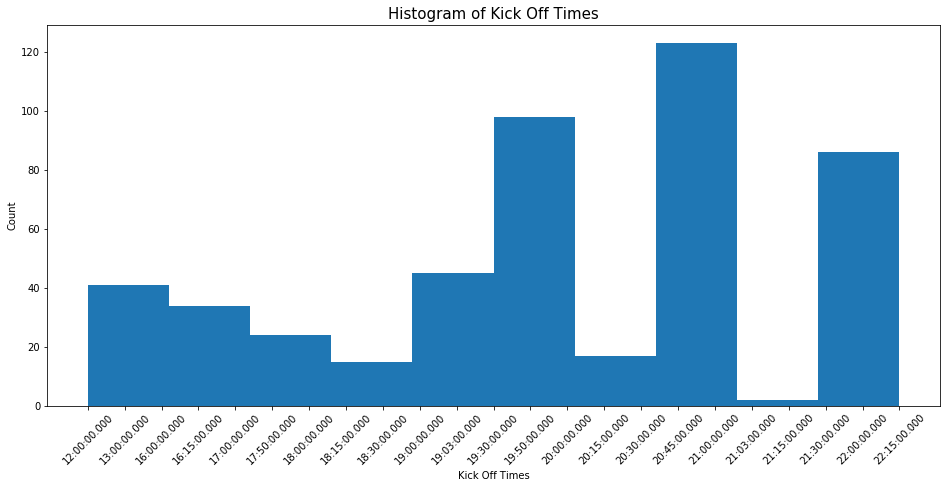

In [237]:
matches_df['kick_offs'].sort_values().hist(figsize = (16,7))
plt.grid(None)
plt.xlabel('Kick Off Times')
plt.ylabel('Count')
plt.title('Histogram of Kick Off Times', fontsize = 15)
plt.xticks(rotation = 45);

Its decided to split the kick off times into 3 groups:

- Early Kick Offs before 6pm
- Mid Kick Offs between 6pm and 8pm
- Late Kick Off after 8pm

In [243]:
kos = np.array([int(n.split(':')[0]) for n in matches_df['kick_offs']])

matches_df['early_ko'] = (kos <= 18).astype(int)
matches_df['mid_ko'] = ((kos <= 20 )& (kos > 18)).astype(int)
matches_df['late_ko'] = (kos > 20).astype(int)

matches_df = matches_df.drop('kick_offs', axis = 1)
matches_df

,match_dates,season_names,home_teams,away_teams,home_scores,away_scores,match_weeks,home_team_wins,early_ko,mid_ko,late_ko
68353,2004-10-16,37,214,217,0,1,7,0,0,0,1
68313,2004-10-24,37,217,422,3,0,8,1,0,0,1
68314,2004-12-04,37,217,223,4,0,14,1,0,1,0
69153,2004-12-11,37,608,217,1,2,15,0,0,1,0
68315,2004-12-21,37,217,221,2,1,17,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...
303725,2020-07-05,42,222,217,1,4,34,0,0,0,1
303615,2020-07-08,42,217,214,1,0,35,1,0,0,1
303680,2020-07-11,42,901,217,0,1,36,0,0,1,0
303634,2020-07-16,42,217,422,1,2,37,0,0,0,1


It was also decided to split out the dates into `year`, `month` and `day` variables to identify any relationships between the home team winning and the time of year etc. For example, do the home teams perform better in the latter part of the season? The `weekdays` variable was also created to see if midweek games have any influence on whether the home team wins or not. 

In [244]:
type(matches_df['match_dates'].values[0])

str

In [245]:
# Monday is 0 and Sunday is 6

matches_df['weekdays'] = [datetime.strptime(n, '%Y-%m-%d').weekday() for n in matches_df['match_dates']]
matches_df['year'] = [datetime.strptime(n, '%Y-%m-%d').year for n in matches_df['match_dates']]
matches_df['month'] = [datetime.strptime(n, '%Y-%m-%d').month for n in matches_df['match_dates']]
matches_df['day'] = [datetime.strptime(n, '%Y-%m-%d').day for n in matches_df['match_dates']]

matches_df = matches_df.drop('match_dates', axis = 1)
matches_df

,season_names,home_teams,away_teams,home_scores,away_scores,match_weeks,home_team_wins,early_ko,mid_ko,late_ko,weekdays,year,month,day
68353,37,214,217,0,1,7,0,0,0,1,5,2004,10,16
68313,37,217,422,3,0,8,1,0,0,1,6,2004,10,24
68314,37,217,223,4,0,14,1,0,1,0,5,2004,12,4
69153,37,608,217,1,2,15,0,0,1,0,5,2004,12,11
68315,37,217,221,2,1,17,1,0,1,0,1,2004,12,21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
303725,42,222,217,1,4,34,0,0,0,1,6,2020,7,5
303615,42,217,214,1,0,35,1,0,0,1,2,2020,7,8
303680,42,901,217,0,1,36,0,0,1,0,5,2020,7,11
303634,42,217,422,1,2,37,0,0,0,1,3,2020,7,16


A final look at the distributions is useful.

For `home_team_wins` there is an even split between the outcomes which is helpful. It reduces the impact minority values can have on the analysis. 

For `away_scores` and `home_scores` there is a tendency for low values which is not surprising. Interestingly, the most frequent value for `away_scores` is 0 and for `home_scores` it appears to be 1 or 2. This is some intial evidence that the home team tends to score more goals. 

`home_teams`, `away_teams`, `season_names` are id numbers with no logical distributions so no real inference can be made from their distributions.

Most games in the sample appear to be played at the weekend, so its unclear whether there are enough weekday games for any modelling to identify any relationships. 

`month` shows that there are more games in the sample that were played in the winter months. While there does tend to be a summer break between football seasons, there appears to be a slight inbalance in the data. This could cause prediction errors when using any trained model on unseen data as the model is trained with more winter games. 

Ideally, more samples from the spring and autumn months would be collected. Another option is to remove some of the matches from the winter months. For the purposes of the analysis, no modifications will be made due to the already small sample size. Caution when using the model on out of sample data is noted.

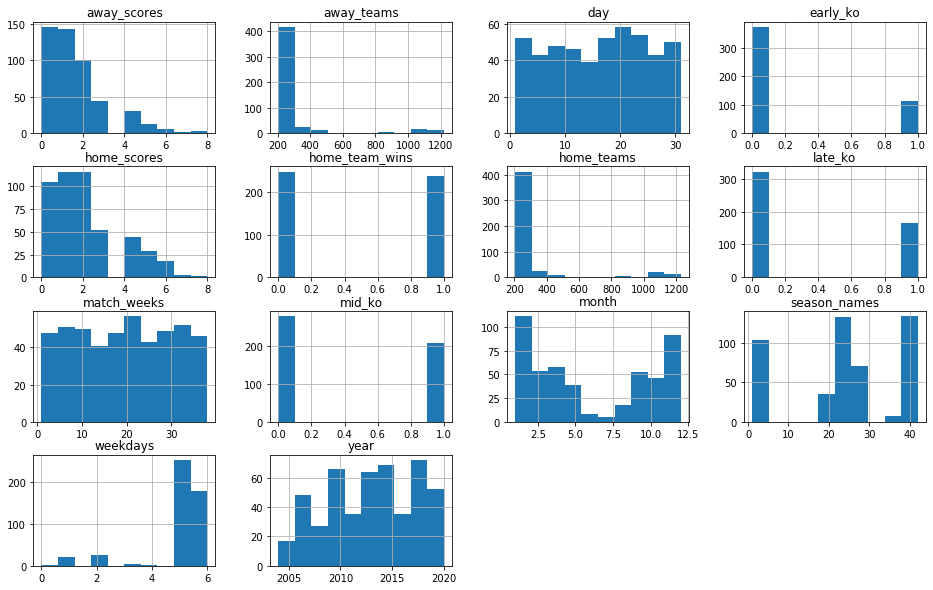

In [252]:
for col in matches_df.columns: 
    matches_df[col] = matches_df[col].astype(int)
    
matches_df.hist(figsize = (16, 10));

## Splitting the data

Next the data is split between input and target variables, and also between training and test data. The model is trained on the training data and then tested on the unseen test data to determine the models predictive ability. 

In [265]:
target = 'home_team_wins'
features = matches_df.drop(target, axis = 1).columns
X = matches_df.drop(target, axis = 1).values
y = matches_df[target].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [254]:
features

Index(['season_names', 'home_teams', 'away_teams', 'home_scores',
       'away_scores', 'match_weeks', 'early_ko', 'mid_ko', 'late_ko',
       'weekdays', 'year', 'month', 'day'],
      dtype='object')

In [255]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((388, 13), (97, 13), (388,), (97,))

## Scaling the data

To ensure model stability, the input variables are scaled. 

In [256]:
scaler = MinMaxScaler()

scaler.fit(X_train)
scaled_X_train = scaler.transform(X_train) # each column ranges from 0 to 1
scaled_X_test = scaler.transform(X_test)

## Logistic Regression

It is not always necessary to use the most complex deep learning models for prediction. Sometimes, less complex models can perform well. The added bonus is that less complex models are often easier to interpret. 

L2 regularisation is applied to add a penalty to the loss function while the model is training. Overly complex models are penalised meaning that only the most informationally important variables are identified. Smaller `C` values will enforce more regularisation, making some variables close weighting close to 0. A value of 1 is applied. 

The 'liblinear' optimiser is a suitable choice for training small datasets. 

In [257]:
logistic_model = LogisticRegression(
    penalty = 'l2', 
    C = 1.0, # regularisation strength
    solver = 'liblinear', # works well on small datasets
).fit(scaled_X_train, y_train)

__The most important variables are given below.__

Its interesting to see the `weekdays` variable is ranked most important, given the initial thoughts on the smaller frequency of weekday matches in the sample. A follow up on this finding would be to identify the games played during the week and inspecting whether there is a noticable trend in the home team winning or losing. 

Unsurprisingly, the `home_scores` variable is important. But strangely, the `away_scores` is less importantant. 

The kick-off time appears to have little impact. 

The `away_teams` variable is also important, suggesting a weaker opponent may increase the probability of a home team victory. 

In [266]:
selector = RFE(logistic_model, n_features_to_select = 1)
selector.fit(scaled_X_train, y_train)
order = selector.ranking_
order

array([10,  3,  4,  1,  2, 12,  6, 13, 11,  9,  7,  5,  8])

In [267]:
feature_ranks = [f'{i} - {features[i-1]}' for i in order]
feature_ranks

['10 - weekdays',
 '3 - away_teams',
 '4 - home_scores',
 '1 - season_names',
 '2 - home_teams',
 '12 - month',
 '6 - match_weeks',
 '13 - day',
 '11 - year',
 '9 - late_ko',
 '7 - early_ko',
 '5 - away_scores',
 '8 - mid_ko']

## Predictions

The trained model is then used to predict the outcomes of the matches contained in the unseen dataset of `scaled_X_test`

In [261]:
y_pred = logistic_model.predict(scaled_X_test)

In [262]:
pred_results = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
pred_results

,Actual,Predicted
0,0,0
1,1,1
2,0,0
3,1,1
4,1,1
...,...,...
92,0,0
93,0,0
94,0,0
95,0,0


In [263]:
confusion_matrix(y_test, y_pred)

array([[45,  0],
       [ 2, 50]])

In [264]:
print(f'Accuracy score: {accuracy_score(y_test, y_pred)}')
print(f'Precision score: {precision_score(y_test, y_pred)}')
print(f'Recall score: {recall_score(y_test, y_pred)}')

Accuracy score: 0.979381443298969
Precision score: 1.0
Recall score: 0.9615384615384616


## Results & Analysis

It appears that the logistic regression does a very good job at predicting whether or not the home team will win. Given the high accuracy score of 97.9%, there is not much to be gained from using a more complex modelling technique such as a neural networks. 

For future study, a complete dataset would be useful. Barcelona are one of the best teams in the world and its possible the model is simply identifying if Barcelona are the home or away team and determining the result based on that information. 

More spring and autumn fixtures may lead to different results. For example, if Barcelona are playing in the later stages of the Champions League in the spring, their La Liga matches may show a slight increase in losses as the focus would be on winning the Champions League. 

Testing the model in different leagues would be interesting to see if the same dynamics present in La Liga are common to other competitions. 

Overall, the model performance is impressive for the humble logistic regression model. Sometimes simplicity > complexity. 